# Demo: SSVQE basics

WQ 07/18/2022



##### The Subspace-search variational quantum eigensolver (SSVQE) algorithm is described in [Subspace-search variational quantum eigensolver for excited states](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.1.033062)

##### This notebook is a demo on how to use SSVQE simulation with 
* Exact simulator
* QASM simulator
* Noise model QASM simulator
* Noise model QASM simulator with readout-error mitigation

##### which is used in the recent paper, [Solving hadron structures using the basis light-front quantization approach on quantum computers](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.4.043193).

##### Note:
1. In practice, we would need to run simulation multiple times to obtain reasonable results.
1. I have suppressed most of the simulation run output because they are very long to render on GitHub.
2. The generated data are stored as PICKLE files under output/ssvqe_basic/ directory.

In [1]:
import os, sys, importlib
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from time import time
%matplotlib inline

from qiskit import Aer
from qiskit.algorithms import NumPyEigensolver, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import L_BFGS_B, COBYLA, SLSQP, SPSA, QNSPSA
from qiskit.circuit.library import EfficientSU2
from qiskit.utils import QuantumInstance

# Local package
library = os.path.abspath("./src")
assert os.path.isdir(library)
if library not in sys.path: 
    sys.path.append(library)
    
import operators, tools, visualization, simulator 
import init_state, ansatz, optimization_result
import solver_VQE, solver_SSVQE

from qiskit import IBMQ, Aer
from qiskit.providers.aer.noise import NoiseModel
from qiskit.utils.mitigation import CompleteMeasFitter
from simulator import sv_qi, qasm_qi, qasm_sim, sv_sim, make_qi

# Problem setup

We take a 4x4 Hamiltonian matrix as an example.

In [2]:
fn_N1L1 = f'H_data/N1L1/Ham_Total_a0p89_mf0p30_kap0p56_mJ0_mug0.02_grid64_N1_L1_lambda0p00.dat'
fn_N4L1 = f'H_data/N4L1/Ham_Total_a0p89_mf0p38_kap0p56_mJ0_mug0.02_grid64_N4_L1_lambda0p00.dat'
fn_N4L3 = f"H_data/N4L3/Ham_Total_a0p89_mf0p40_kap0p56_mJ0_mug0.02_grid64_N4_L3_lambda0p00.dat"

In [3]:
def get_Ham_and_Operator_and_Exact_from_files(N=1, L=1, encoding='compact', verbose=0):
    fn = ""
    if N==1 and L==1: fn = fn_N1L1
    if N==4 and L==1: fn = fn_N4L1
    if N==4 and L==3: fn = fn_N4L3
    assert fn != "", "Invalid N and L parameters!"
    Hamiltonian = tools.load_Ham_data_by_threshold(fn)
    Hamiltonian = Hamiltonian*1000*1000    # mass squared energy units: GeV^2 to MeV^2
    operator = operators.MatrixEncoding(Hamiltonian, encoding=encoding).get_operator()
    exact = list(sorted(np.linalg.eigvals(Hamiltonian)))
    if verbose != 0: 
        print(Hamiltonian)
        print()
        print(operator)
        print()
        print(exact)    
    return Hamiltonian, operator, exact

Hamiltonian, operator, exact = get_Ham_and_Operator_and_Exact_from_files(N=1, L=1, encoding='compact', verbose=1)

[[ 568486.7        0.     25428.09       0.  ]
 [      0.   1700976.         0.    -15766.91]
 [  25428.09       0.    568486.7        0.  ]
 [      0.    -15766.91       0.   1700976.  ]]

1134731.35 * II
- 566244.6499999999 * IZ
+ 4830.590000000001 * XI
+ 20597.5 * XZ

[543058.6100000001, 593914.79, 1685209.09, 1716742.91]


[543058.6100000001, 593914.79, 1685209.09, 1716742.91]
Expected cost = 1475911.14125
Depth = 8
Num Params = 12


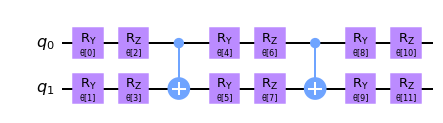

In [4]:
n_qubit = 2
n_state = 4

Hamiltonian, operator, exact = get_Ham_and_Operator_and_Exact_from_files(N=1, L=1, encoding='compact')
print(exact[:n_state])
print("Expected cost =", sum(exact[i]*(1/2**i) for i in range(n_state)))

# ANSATZ
myansatz = EfficientSU2(n_qubit, ['ry', 'rz'], 'linear', reps=2).decompose()
# myansatz = HEA_ansatz(4, 6, ['ry'])
# myansatz = ALT_ansatz(4, 2, 3, ['ry'], barrier=False, block_depth=2, random_pauli=False, final_rotation=False)
# myansatz = apply_start_ry_to_ansatz(myansatz)
print("Depth =", myansatz.depth())
print("Num Params =", myansatz.num_parameters)

# INITIAL STATES
ref_states = init_state.get_ref_states(n_qubit, n_state)
# ref_states = [init_state.build_ref_state_for_UCC([0], 4)]

myansatz.draw()

## EXACT

In [5]:
# INITIAL PARAMS
myparams = np.random.random(myansatz.num_parameters)
myparams

array([0.5088896 , 0.78984968, 0.27858482, 0.88222792, 0.82869311,
       0.55049793, 0.36679208, 0.72066796, 0.72821067, 0.25211684,
       0.66033492, 0.31480151])

In [ ]:
# EXACT SSVQE
mySSVQE = solver_SSVQE.SSVQE_solver(
    myansatz, operator, ref_states, optimizer_name="L_BFGS_B", 
    initial_point=myparams,
    verbose=1, max_iter=150)
result = mySSVQE.run()

In [30]:
# CHECK SIMULATION DETAILS
# result.cost_hist
# result.error_hist
# result.eval_hist
# result.final_param
# result.final_eval
# result.n_iter

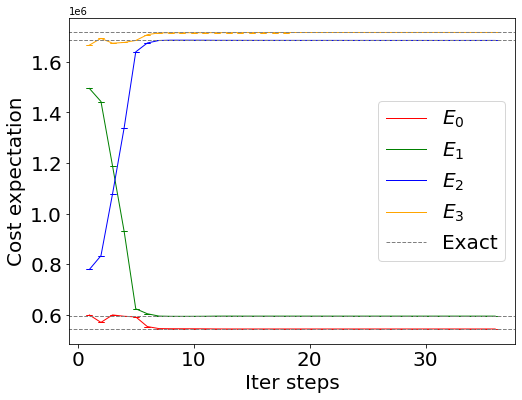

In [7]:
# VISUALIZATION (since exact, no error)
result.plot_evals(0, show_err=True, labels=[r'$E_0$', r'$E_1$', r'$E_2$', r'$E_3$'][:n_state], ref_evals=exact[:n_state], figsize=(8, 6), fs=20)

In [8]:
# SAVING EVERYTHING
result.save("output/ssvqe_basic/ssvqe_2qubit_4ref_exact_LBFGSB") 

OptimizationResult saved to output/ssvqe_basic/ssvqe_2qubit_4ref_exact_LBFGSB_07_16_14_38_23.pk.


'output/ssvqe_basic/ssvqe_2qubit_4ref_exact_LBFGSB_07_16_14_38_23.pk'

In [9]:
# START SAME INITIAL PARAMS BUT WITH ANOTHER OPTIMIZER
myparams = np.array([0.5088896 , 0.78984968, 0.27858482, 0.88222792, 0.82869311,
       0.55049793, 0.36679208, 0.72066796, 0.72821067, 0.25211684,
       0.66033492, 0.31480151])
myparams

array([0.5088896 , 0.78984968, 0.27858482, 0.88222792, 0.82869311,
       0.55049793, 0.36679208, 0.72066796, 0.72821067, 0.25211684,
       0.66033492, 0.31480151])

In [ ]:
# EXACT SSVQE
mySSVQE = solver_SSVQE.SSVQE_solver(
    myansatz, operator, ref_states, optimizer_name="COBYLA", 
    initial_point=myparams,
    verbose=1, max_iter=150)
result = mySSVQE.run()

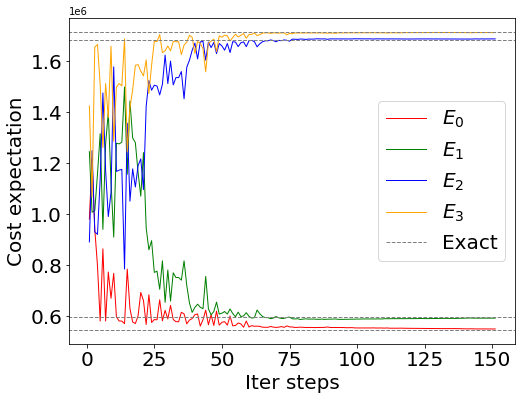

In [11]:
# VISUALIZATION
result.plot_evals(0, show_err=False, labels=[r'$E_0$', r'$E_1$', r'$E_2$', r'$E_3$'][:n_state], ref_evals=exact[:n_state], figsize=(8, 6), fs=20)

In [12]:
# SAVING EVERYTHING
result.save("output/ssvqe_basic/ssvqe_2qubit_4ref_exact_COBYLA") 

OptimizationResult saved to output/ssvqe_basic/ssvqe_2qubit_4ref_exact_COBYLA_07_16_14_40_30.pk.


'output/ssvqe_basic/ssvqe_2qubit_4ref_exact_COBYLA_07_16_14_40_30.pk'

## QASM

In [13]:
# START SAME INITIAL PARAMS FOR COMPARISON
myparams = np.array([0.5088896 , 0.78984968, 0.27858482, 0.88222792, 0.82869311,
       0.55049793, 0.36679208, 0.72066796, 0.72821067, 0.25211684,
       0.66033492, 0.31480151])
myparams

array([0.5088896 , 0.78984968, 0.27858482, 0.88222792, 0.82869311,
       0.55049793, 0.36679208, 0.72066796, 0.72821067, 0.25211684,
       0.66033492, 0.31480151])

In [ ]:
# SHOT-BASED SIMULATION, QASM, WITH 20000 SHOTS
mySSVQE = solver_SSVQE.SSVQE_solver(
    myansatz, operator, ref_states, optimizer_name="COBYLA", 
    quantum_instance=make_qi(qasm_sim, 20000), 
    exp_method='pauli',
    initial_point=myparams,
    verbose=1, max_iter=200)
result = mySSVQE.run()

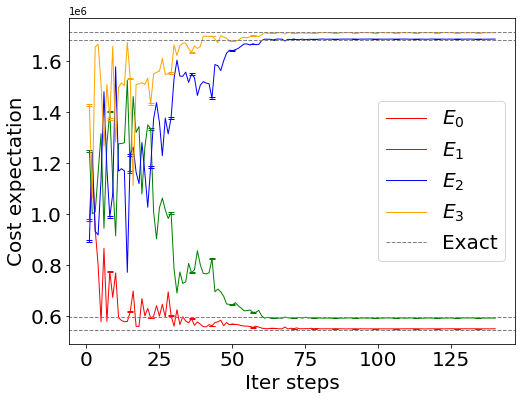

In [15]:
# VISUALIZATION
result.plot_evals(0, show_err=True, labels=[r'$E_0$', r'$E_1$', r'$E_2$', r'$E_3$'][:n_state], ref_evals=exact[:n_state], figsize=(8, 6), fs=20)

In [16]:
# SAVING EVERYTHING
result.save("output/ssvqe_basic/ssvqe_2qubit_4ref_qasm_COBYLA") 

OptimizationResult saved to output/ssvqe_basic/ssvqe_2qubit_4ref_qasm_COBYLA_07_16_14_41_43.pk.


'output/ssvqe_basic/ssvqe_2qubit_4ref_qasm_COBYLA_07_16_14_41_43.pk'

In [17]:
# START SAME INITIAL PARAMS FOR COMPARISON
myparams = np.array([0.5088896 , 0.78984968, 0.27858482, 0.88222792, 0.82869311,
       0.55049793, 0.36679208, 0.72066796, 0.72821067, 0.25211684,
       0.66033492, 0.31480151])
myparams

array([0.5088896 , 0.78984968, 0.27858482, 0.88222792, 0.82869311,
       0.55049793, 0.36679208, 0.72066796, 0.72821067, 0.25211684,
       0.66033492, 0.31480151])

In [ ]:
# SHOT-BASED SIMULATION, QASM, WITH 20000 SHOTS
mySSVQE = solver_SSVQE.SSVQE_solver(
    myansatz, operator, ref_states, optimizer_name="SPSA", 
    quantum_instance=make_qi(qasm_sim, 20000), 
    exp_method='pauli',
    initial_point=myparams,
    verbose=1, max_iter=500, random_seed=0)
result = mySSVQE.run()

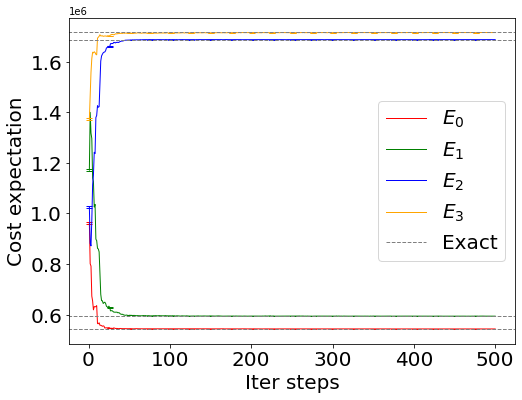

In [19]:
# VISUALIZATION
result.plot_evals(0, show_err=True, labels=[r'$E_0$', r'$E_1$', r'$E_2$', r'$E_3$'][:n_state], ref_evals=exact[:n_state], figsize=(8, 6), fs=20)

In [20]:
result.save("output/ssvqe_basic/ssvqe_2qubit_4ref_qasm_SPSA")

OptimizationResult saved to output/ssvqe_basic/ssvqe_2qubit_4ref_qasm_SPSA_07_16_14_44_30.pk.


'output/ssvqe_basic/ssvqe_2qubit_4ref_qasm_SPSA_07_16_14_44_30.pk'

# Noise simulation (Nairobi)

One can also use the Fake backends provided by Qiskit, which builds a noisy simulator automatically based on real-time status of the quantum computer.

In [ ]:
# BASIC NOISE MODEL
provider = IBMQ.load_account()
backend = provider.get_backend('ibm_nairobi')
noise_model = NoiseModel.from_backend(backend)
print(noise_model)

In [23]:
# PROPERTIES
coupling_map = backend.configuration().coupling_map; coupling_map;

In [24]:
# QUANTUM INSTANCE OF THE NOISE MODEL, USED IN OPTIMIZATION
noise_qi = QuantumInstance(qasm_sim, shots=20000, noise_model=noise_model, coupling_map=coupling_map)
noise_qi.noise_config

{'noise_model': <NoiseModel on ['measure', 'cx', 'id', 'reset', 'x', 'sx']>}

In [25]:
# START SAME INITIAL PARAMS FOR COMPARISON
myparams = np.array([0.5088896 , 0.78984968, 0.27858482, 0.88222792, 0.82869311,
       0.55049793, 0.36679208, 0.72066796, 0.72821067, 0.25211684,
       0.66033492, 0.31480151])
myparams

array([0.5088896 , 0.78984968, 0.27858482, 0.88222792, 0.82869311,
       0.55049793, 0.36679208, 0.72066796, 0.72821067, 0.25211684,
       0.66033492, 0.31480151])

In [ ]:
# SHOT-BASED NOISY SIMULATION BASED ON IBM_NAIROBI, WITH 20000 SHOTS
# IN THEORY, THIS SIMLATES WHAT IT LOOKS LIKE ON QUANTUM COMPUTER, IBM_NAIROBI, BUT IT IS TOO OPTIMISTIC
mySSVQE = solver_SSVQE.SSVQE_solver(
    myansatz, operator, ref_states, optimizer_name="COBYLA", 
    quantum_instance=noise_qi, 
    exp_method='pauli',
    initial_point=myparams,
    verbose=1, max_iter=500)
result = mySSVQE.run()

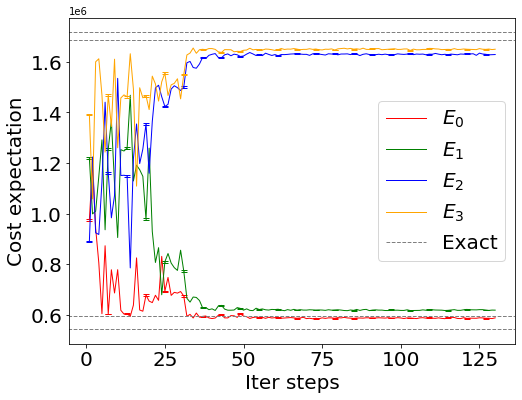

In [27]:
# VISUALIZATION
result.plot_evals(0, show_err=True, labels=[r'$E_0$', r'$E_1$', r'$E_2$', r'$E_3$'][:n_state], ref_evals=exact[:n_state], figsize=(8, 6), fs=20)

In [28]:
result.save("output/ssvqe_basic/ssvqe_2qubit_4ref_nqasm_COBYLA")

OptimizationResult saved to output/ssvqe_basic/ssvqe_2qubit_4ref_nqasm_COBYLA_07_16_14_46_26.pk.


'output/ssvqe_basic/ssvqe_2qubit_4ref_nqasm_COBYLA_07_16_14_46_26.pk'

In [ ]:
# SHOT-BASED NOISY SIMULATION BASED ON IBM_NAIROBI, WITH 20000 SHOTS
# IN THEORY, THIS SIMLATES WHAT IT LOOKS LIKE ON QUANTUM COMPUTER, IBM_NAIROBI, BUT IT IS TOO OPTIMISTIC
mySSVQE = solver_SSVQE.SSVQE_solver(
    myansatz, operator, ref_states, optimizer_name="SPSA", 
    quantum_instance=noise_qi, 
    exp_method='pauli',
    initial_point=myparams,
    verbose=1, max_iter=500, random_seed=13) # use a random seed to fix result
result = mySSVQE.run()

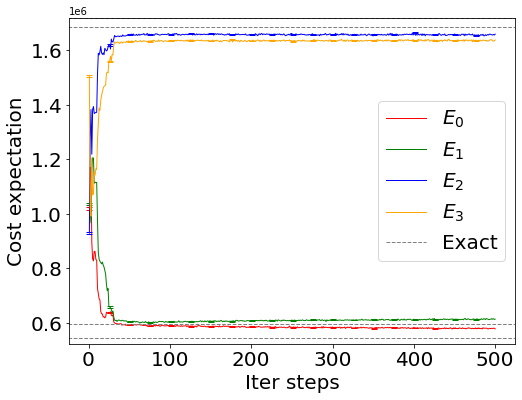

In [30]:
# VISUALIZATION
result.plot_evals(0, show_err=True, labels=[r'$E_0$', r'$E_1$', r'$E_2$', r'$E_3$'][:n_state], ref_evals=exact[:n_state], figsize=(8, 6), fs=20)

In [31]:
result.save("output/ssvqe_basic/ssvqe_2qubit_4ref_nqasm_SPSA")

OptimizationResult saved to output/ssvqe_basic/ssvqe_2qubit_4ref_nqasm_SPSA_07_16_14_53_11.pk.


'output/ssvqe_basic/ssvqe_2qubit_4ref_nqasm_SPSA_07_16_14_53_11.pk'

# Noise-mitigated simulation (Nairobi)

In [ ]:
# BASIC NOISE MODEL
provider = IBMQ.load_account()
backend = provider.get_backend('ibm_nairobi')
noise_model = NoiseModel.from_backend(backend)
print(noise_model)

In [90]:
# PROPERTIES
coupling_map = backend.configuration().coupling_map; coupling_map;

In [32]:
# QUANTUM INSTANCE OF THE NOISE MODEL WITH MITIGATIONS, USED IN OPTIMIZATION
noise_miti_qi = QuantumInstance(qasm_sim, shots=20000, noise_model=noise_model, coupling_map=coupling_map,
                                measurement_error_mitigation_cls=CompleteMeasFitter, cals_matrix_refresh_period=90)

In [33]:
# START SAME INITIAL PARAMS FOR COMPARISON
myparams = np.array([0.5088896 , 0.78984968, 0.27858482, 0.88222792, 0.82869311,
       0.55049793, 0.36679208, 0.72066796, 0.72821067, 0.25211684,
       0.66033492, 0.31480151])
myparams

array([0.5088896 , 0.78984968, 0.27858482, 0.88222792, 0.82869311,
       0.55049793, 0.36679208, 0.72066796, 0.72821067, 0.25211684,
       0.66033492, 0.31480151])

In [ ]:
# SHOT-BASED NOISY SIMULATION BASED ON IBM_NAIROBI, WITH 20000 SHOTS, WITH READOUT ERROR MITIGATIONS
mySSVQE = solver_SSVQE.SSVQE_solver(
    myansatz, operator, ref_states, optimizer_name="COBYLA", 
    quantum_instance=noise_miti_qi, 
    exp_method='pauli',
    initial_point=myparams,
    verbose=1, max_iter=500)
result = mySSVQE.run()

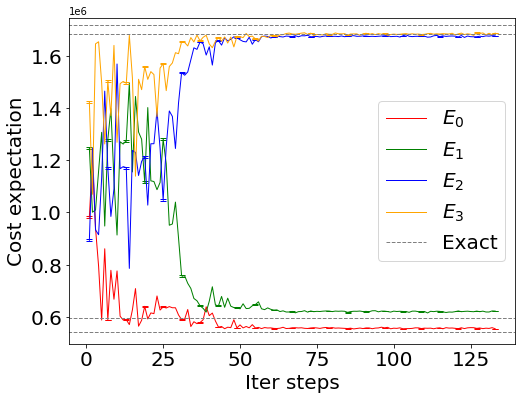

In [35]:
# VISUALIZATION
result.plot_evals(0, show_err=True, labels=[r'$E_0$', r'$E_1$', r'$E_2$', r'$E_3$'][:n_state], ref_evals=exact[:n_state], figsize=(8, 6), fs=20)

In [36]:
result.save("output/ssvqe_basic/ssvqe_2qubit_4ref_nmqasm_COBYLA")

OptimizationResult saved to output/ssvqe_basic/ssvqe_2qubit_4ref_nmqasm_COBYLA_07_16_14_53_47.pk.


'output/ssvqe_basic/ssvqe_2qubit_4ref_nmqasm_COBYLA_07_16_14_53_47.pk'

In [37]:
myparams = np.array([0.5088896 , 0.78984968, 0.27858482, 0.88222792, 0.82869311,
       0.55049793, 0.36679208, 0.72066796, 0.72821067, 0.25211684,
       0.66033492, 0.31480151])
myparams

array([0.5088896 , 0.78984968, 0.27858482, 0.88222792, 0.82869311,
       0.55049793, 0.36679208, 0.72066796, 0.72821067, 0.25211684,
       0.66033492, 0.31480151])

In [ ]:
# SHOT-BASED NOISY SIMULATION BASED ON IBM_NAIROBI, WITH 20000 SHOTS, WITH READOUT ERROR MITIGATIONS
mySSVQE = solver_SSVQE.SSVQE_solver(
    myansatz, operator, ref_states, optimizer_name="COBYLA", 
    quantum_instance=noise_miti_qi, 
    exp_method='pauli',
    initial_point=myparams,
    verbose=1, max_iter=500)
result = mySSVQE.run()

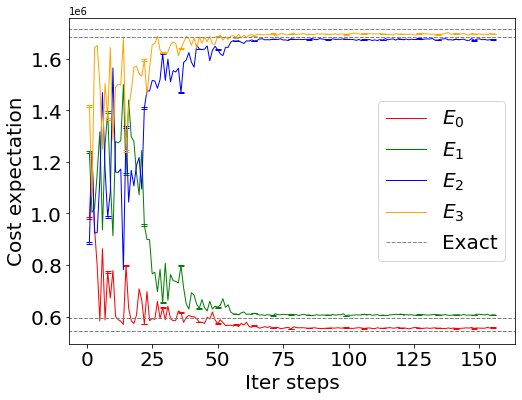

In [39]:
# VISUALIZATION
result.plot_evals(0, show_err=True, labels=[r'$E_0$', r'$E_1$', r'$E_2$', r'$E_3$'][:n_state], ref_evals=exact[:n_state], figsize=(8, 6), fs=20)

In [40]:
result.save("output/ssvqe_basic/ssvqe_2qubit_4ref_nmqasm_COBYLA")

OptimizationResult saved to output/ssvqe_basic/ssvqe_2qubit_4ref_nmqasm_COBYLA_07_16_14_54_29.pk.


'output/ssvqe_basic/ssvqe_2qubit_4ref_nmqasm_COBYLA_07_16_14_54_29.pk'

In [43]:
myparams = np.array([0.5088896 , 0.78984968, 0.27858482, 0.88222792, 0.82869311,
       0.55049793, 0.36679208, 0.72066796, 0.72821067, 0.25211684,
       0.66033492, 0.31480151])
myparams

array([0.5088896 , 0.78984968, 0.27858482, 0.88222792, 0.82869311,
       0.55049793, 0.36679208, 0.72066796, 0.72821067, 0.25211684,
       0.66033492, 0.31480151])

In [44]:
# SHOT-BASED NOISY SIMULATION BASED ON IBM_NAIROBI, WITH 20000 SHOTS, WITH READOUT ERROR MITIGATIONS
mySSVQE = solver_SSVQE.SSVQE_solver(
    myansatz, operator, ref_states, optimizer_name="SPSA", 
    quantum_instance=noise_miti_qi, 
    exp_method='pauli',
    initial_point=myparams,
    verbose=1, max_iter=500)
result = mySSVQE.run()


Optimization started...
[0.5088896  0.78984968 0.27858482 0.88222792 0.82869311 0.55049793
 0.36679208 0.72066796 0.72821067 0.25211684 0.66033492 0.31480151]

|   1|  0h  0m 14s | cost = 2009779.106 (7313.220) | evals = [1004929, 1160437, 1039378, 1318295]
|   2|  0h  0m 15s | cost = 1944048.999 (6466.903) | evals = [818111, 1418313, 1033485, 1267281]
|   3|  0h  0m 16s | cost = 2101655.942 (7413.495) | evals = [1156705, 1066359, 979527, 1335119]
|   4|  0h  0m 17s | cost = 2024191.054 (7306.508) | evals = [1044010, 994351, 1362957, 1138128]
|   5|  0h  0m 17s | cost = 1808174.319 (5240.601) | evals = [638974, 1370772, 1360572, 1149369]
|   6|  0h  0m 18s | cost = 1756651.417 (5018.321) | evals = [636913, 1359182, 986075, 1549034]
|   7|  0h  0m 19s | cost = 1680248.789 (4866.470) | evals = [610580, 1131440, 1250847, 1529895]
|   8|  0h  0m 20s | cost = 1630878.892 (4355.382) | evals = [596243, 958502, 1469240, 1504596]
|   9|  0h  0m 21s | cost = 1629858.773 (4322.274) | evals = [59

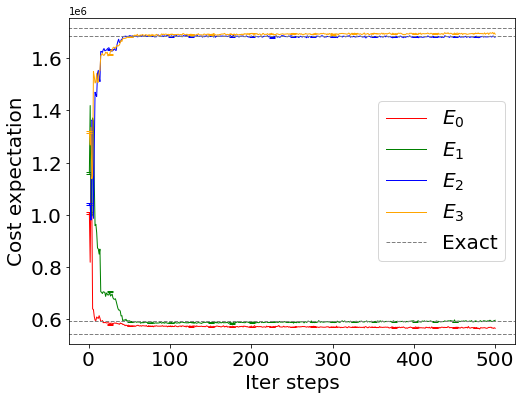

In [45]:
# VISUALIZATION
result.plot_evals(0, show_err=True, labels=[r'$E_0$', r'$E_1$', r'$E_2$', r'$E_3$'][:n_state], ref_evals=exact[:n_state], figsize=(8, 6), fs=20)

In [46]:
result.save("output/ssvqe_basic/ssvqe_2qubit_4ref_nmqasm_SPSA")

OptimizationResult saved to output/ssvqe_basic/ssvqe_2qubit_4ref_nmqasm_SPSA_07_16_15_11_25.pk.


'output/ssvqe_basic/ssvqe_2qubit_4ref_nmqasm_SPSA_07_16_15_11_25.pk'

## Multiple runs

In [125]:
# INITIAL PARAMS
myparams = np.random.random(myansatz.num_parameters)
myparams

array([0.88698307, 0.5280797 , 0.38115028, 0.37063284, 0.8088314 ,
       0.96851671, 0.56043501, 0.23358377, 0.9810275 , 0.68533701,
       0.03572298, 0.0742113 ])

In [134]:
# EXACT SSVQE
mySSVQE = solver_SSVQE.SSVQE_solver(
    myansatz, operator, ref_states, optimizer_name="COBYLA", 
    quantum_instance=noise_miti_qi, 
    exp_method='pauli',
    initial_point=myparams,
    verbose=1, max_iter=150)

In [ ]:
num_runs = 3
for _ in range(num_runs):
    mySSVQE.run()

In [136]:
mySSVQE.optim_result

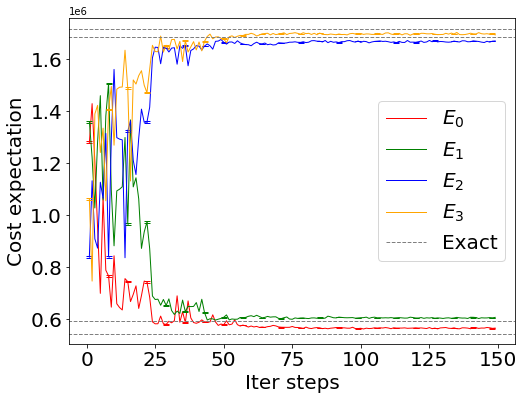

In [140]:
# VISUALIZATION
mySSVQE.optim_result.plot_evals(0, show_err=True, labels=[r'$E_0$', r'$E_1$', r'$E_2$', r'$E_3$'][:n_state], ref_evals=exact[:n_state], figsize=(8, 6), fs=20)

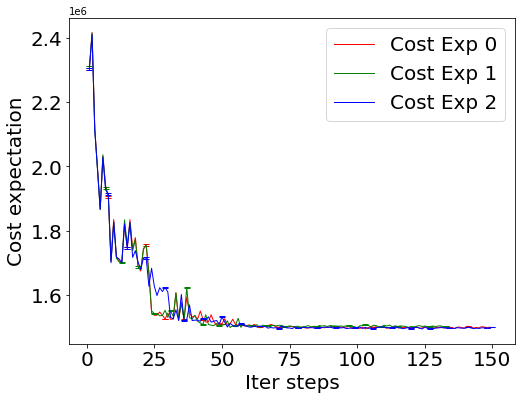

In [138]:
# TOTAL COST
mySSVQE.optim_result.plot_costs([0,1,2], show_err=True, figsize=(8, 6), fs=20)

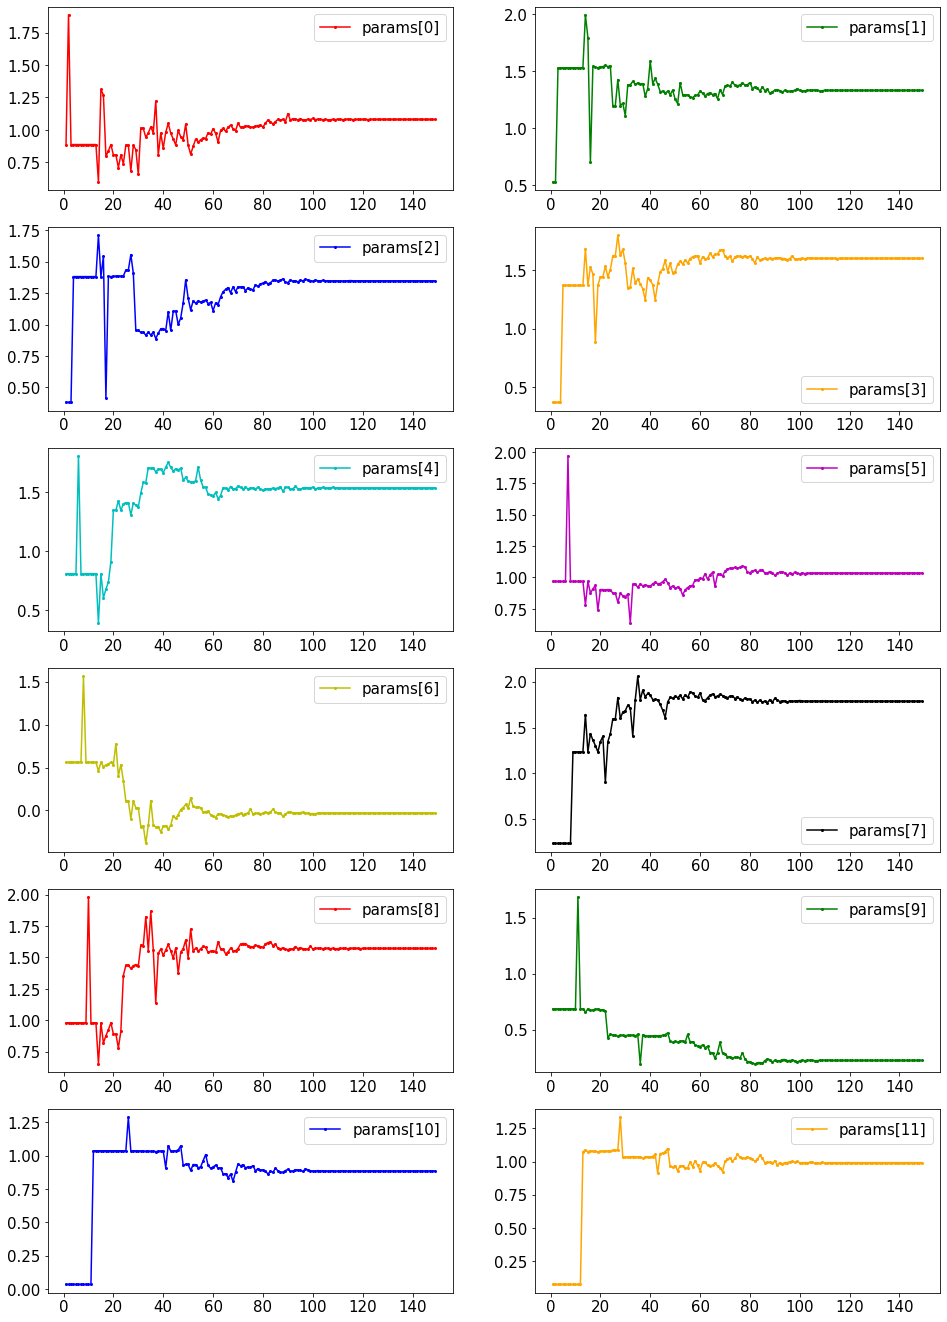

In [139]:
# PARAMETER CONVERGENCES
mySSVQE.optim_result.plot_params(idx=0)